In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
import math
from astropy import units as u
from astropy.modeling import models,fitting
from astropy.modeling import Model
from astropy.io import ascii
from astroquery.vizier import Vizier
import starkit
from starkit.fitkit.likelihoods import SpectralChi2Likelihood as Chi2Likelihood, SpectralL1Likelihood
from starkit.gridkit import load_grid
from starkit.fitkit.multinest.base import MultiNest, MultiNestResult
from starkit import assemble_model, operations
from starkit.fitkit import priors
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from starkit.fix_spectrum1d import SKSpectrum1D
from specutils import read_fits_file,plotlines
import numpy as np
import os,scipy
from specutils import Spectrum1D,rvmeasure
import datetime,glob
import model_tester_updated as mt
from matplotlib.backends.backend_pdf import PdfPages
import operator
import sys
from matplotlib.pyplot import cm
import multi_order_fitting_functions as mtf
from scipy.stats.stats import pearsonr, chisquare
from scipy.optimize import curve_fit
from scipy import ndimage as nd
import scipy.stats as stats


In [2]:
gc_stars = ['NE_1_001', 'NE_1_002', 'NE_1_003', 'E7_1_001', 'E7_2_001', 'E7_1_002', 'E7_1_003', 'N2_1_001', 'E5_1_001', 'N2_1_002', 'N2_1_003', 'S1-23']
gc_info = scipy.genfromtxt('/u/rbentley/metallicity/NIRSPEC_GC_Targets_info.tsv', delimiter='\t',dtype=None, skip_header=1)

snr = 30.

[py.warnings         ][WARNING]  /anaconda2/envs/starkit/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  
 (npyio.py:2068)


In [3]:
gc_nirspec = None
star_names = [x[13] for x in gc_info]

for star in gc_stars:
    for tab_star in star_names:
        if star in tab_star:
            star_info = list(gc_info[star_names.index(tab_star)])
            
    if gc_nirspec is None:
        gc_nirspec = star_info
    else:
        gc_nirspec = np.vstack([gc_nirspec, star_info])  
        

In [4]:
gc_nirspec = list(gc_nirspec)

for i in range(len(gc_nirspec)):
    gc_nirspec[i][13] = gc_stars[i]
gc_nirspec.sort(key=lambda x: float(x[11]))

print gc_nirspec

[array(['266.419401', '-29.006733', '8.61', '3.762', '-0.39', '-12.938',
       '-21.43', '12.561', '356.5', '4125', '3.98', '-1.27', '11.56',
       'NE_1_003', '1', '4x900', '2016-04-29', '', '34, 35, 36, 37',
       'NE_1_003_order34_nod1.dat', ''], dtype='|S77'), array(['266.417806', '-29.004574', '3.588', '11.533', '-5.412', '-5.167',
       '-26.452', '20.332', '121.0', '4260', '3.82', '-1.2', '12.84',
       'N2_1_003', '2', '6x900', '2016-05-16 UT', '', '', '', ''],
      dtype='|S77'), array(['266.418064', '-29.004723', '4.398', '10.997', '-4.602', '-5.703',
       '-25.642', '19.796', '121.0', '4358', '3.92', '-1.06', '12.21',
       'N2_1_002', '2', '6x900', '2016-05-16 UT',
       'https://drive.google.com/file/d/0B_YkzZoUSrX-VlBIaFVDU0hWcVU/view?usp=sharing',
       '', '', 'some frames have problems'], dtype='|S77'), array(['266.423589', '-29.008037', '21.795', '-0.934', '12.795',
       '-17.634', '-8.245', '7.865', '201.0', '3662', '2.96', '0.56',
       '11.38', 'E7_1_

('clipping', [2.240232, 2.2703292])
('clipping', [2.1788628, 2.20802])
('clipping', [2.1167107, 2.1449087])
('clipping', [2.2403469, 2.2703373])
('clipping', [2.1811268, 2.2103229])
('clipping', [2.1168036, 2.1450112])
('clipping', [2.2403469, 2.2703373])
('clipping', [2.1811268, 2.2103229])
('clipping', [2.1168036, 2.1450112])
('clipping', [2.2402089, 2.2702091])
('clipping', [2.1809773, 2.2101927])
('clipping', [2.1166763, 2.1448839])
('clipping', [2.2403469, 2.2703373])
('clipping', [2.1811268, 2.2103229])
('clipping', [2.1168036, 2.1450112])
('clipping', [2.2402089, 2.2702091])
('clipping', [2.1756349, 2.2047629])
('clipping', [2.1166763, 2.1448839])
('clipping', [2.2391384, 2.2691774])
('clipping', [2.1756349, 2.2047629])
('clipping', [2.1166763, 2.1448839])
('clipping', [2.2402089, 2.2702091])
('clipping', [2.1809773, 2.2101927])
('clipping', [2.1166763, 2.1448839])
('clipping', [2.240232, 2.2703292])
('clipping', [2.1788628, 2.20802])
('clipping', [2.1167107, 2.1449087])
('clipp

Text(0,0.5,'Normalized Flux')

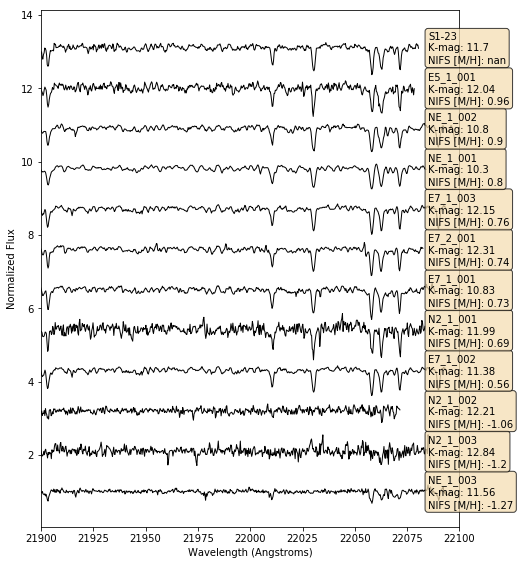

In [10]:
plt.figure(figsize=(7.5, 9.5))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

for i in range(len(gc_nirspec)):
        star_info = gc_nirspec[i]
        starname = star_info[13]

        
        save_path = '/u/rbentley/metallicity/spectra_fits/masked_fit_results/orders34-35-36/BOSZ_fits/unmasked/'

        fitpath = save_path + starname + '_order34-36_bosz_adderr.h5'
        
        result = MultiNestResult.from_hdf5(fitpath)
        
        file1 = glob.glob('/u/rbentley/metallicity/spectra/' + starname + '_order34*.dat')
        file2 = glob.glob('/u/rbentley/metallicity/spectra/' + starname + '_order35*.dat')
        file3 = glob.glob('/u/rbentley/metallicity/spectra/' + starname + '_order36*.dat')

        starspectrum34 = read_fits_file.read_nirspec_dat(file1, desired_wavelength_units='micron')
        starspectrum35 = read_fits_file.read_nirspec_dat(file2, desired_wavelength_units='micron')
        starspectrum36 = read_fits_file.read_nirspec_dat(file3, desired_wavelength_units='micron')

        waverange34 = [np.amin(starspectrum34.wavelength.value[:970]), np.amax(starspectrum34.wavelength.value[:970])]
        waverange35 = [np.amin(starspectrum35.wavelength.value[:970]), np.amax(starspectrum35.wavelength.value[:970])]
        waverange36 = [np.amin(starspectrum36.wavelength.value[:970]), np.amax(starspectrum36.wavelength.value[:970])]

        starspectrum34 = read_fits_file.read_nirspec_dat(file1, desired_wavelength_units='Angstrom',
                                                         wave_range=waverange34)
        starspectrum35 = read_fits_file.read_nirspec_dat(file2, desired_wavelength_units='Angstrom',
                                                         wave_range=waverange35)
        starspectrum36 = read_fits_file.read_nirspec_dat(file3, desired_wavelength_units='Angstrom',
                                                         wave_range=waverange36)


        starspectrum34.uncertainty = (np.zeros(len(starspectrum34.flux.value)) + 1.0 / np.float(
                snr)) * starspectrum34.flux.unit
        starspectrum35.uncertainty = (np.zeros(len(starspectrum35.flux.value)) + 1.0 / np.float(
                snr)) * starspectrum35.flux.unit
        starspectrum36.uncertainty = (np.zeros(len(starspectrum36.flux.value)) + 1.0 / np.float(
                snr)) * starspectrum36.flux.unit

        plt.plot(starspectrum34.wavelength.value / (result.median['vrad_3'] / 3e5 + 1.0), starspectrum34.flux.value+1.1*i,
             color='#000000', label='Data', linewidth=1.0)
        plt.plot(starspectrum35.wavelength.value / (result.median['vrad_4'] / 3e5 + 1.0), starspectrum35.flux.value+1.1*i,
             color='#000000', linewidth=1.0)
        plt.plot(starspectrum36.wavelength.value / (result.median['vrad_5'] / 3e5 + 1.0), starspectrum36.flux.value+1.1*i,
             color='#000000', linewidth=1.0)
        
        plt.text(22085, 0.6+1.1*i,starname+'\nK-mag: '+gc_nirspec[i][12]+'\nNIFS [M/H]: '+gc_nirspec[i][11],
             fontsize=10, bbox=props)
        
plt.xlim(21900, 22100)


plt.xlabel('Wavelength (Angstroms)',fontsize=10)
plt.ylabel('Normalized Flux',fontsize=10)